# **Basics of Mobile Robotics Final Project** 
## **Course: "Basics of Mobile Robotics"(MICRO-452)**
## **Professor: Francesco Mondada**
## **EPFL - December 2023**
### **Authors:**
- Evangelista Santiago Roberto

- Giovine Angelo

- He Weifeng

- Syla Valmir

## **Tables of contents**

- [Demo Videos](#Demo-Videos)

- [Introduction](#Introduction)
  - [Project description and details](#Project-description-and-details)
  - [Modules and libraries required](#Modules-and-libraries-required)

- [Environment](#Environment)

- [Vision](#Vision)
  - [Camera](#Camera)
  - [Environment mapping](#Environment-mapping)
  - [Global obstacle detection](#Global-obstacle-detection)
  - [Robot detection](#Robot-detection)
  - [Goal detection](#Goal-detection)

  

- [Global Navigation](#Global-Navigation)
  - [Visibility graph](#Visibility-graph)



- [Local Navigation](#Local-Navigation)
  - [Local obstacle detection](#Local-obstacle-detection)
  - [Kidnapping](#Kidnapping)

- [Filtering](#Filtering:-Extended-Kalman-Filter)
  - [Why Kalman?](#Deriving-the-state-space-model-of-the-Thymio-Robot)
  - [Two different models](#Two-different-models)
  - [Deriving the state space model of the Thymio Robot](#Deriving-the-state-space-model-of-the-Thymio-Robot)
  - [Dealing with the input](#Dealing-with-the-input)
  - [Experimentation to derive $Cl$ and $Cr$](#Experimentation-to-derive-$Cl$-and-$Cr$)
  - [Calcultating the covariance matrix of the motion model $Q_t$](#Calcultating-the-covariance-matrix-of-the-motion-model-$Q_t$)
  - [Deriving the observation model of the Thymio Robot](#Deriving-the-observation-model-of-the-Thymio-Robot)
  - [Calcultating the covariance matrix of the observation model $R_t$ ](#Calcultating-the-covariance-matrix-of-the-observation-model-$R_t$ )
  - [Implementing the Extended Kalman Filter](#Implementing-the-Extended-Kalman-Filter)



- [Control law ](#Control-law)

- [Main](#Main)

- [The Code](#The-Code)

- [Conclusion](#Conclusion)

- [Sources](#Sources)
  



# **Demo videos**

The optimal path is displayed in white, while the real-time estimated position of the Thymio, obtained through filtering, is indicated by a black dotted line.

Full demo + Normal situation + Kidnapping + Camera obstructed + Local obstacles: https://youtu.be/rz_EOHwGMOw

Full demo: https://youtu.be/DTvLO2GhbcM
    
Normal situation: https://youtu.be/M8M3lAdUMPQ

Kidnapping: https://youtu.be/5M4zRgAHsiA

Camera obstructed: https://youtu.be/vcZKryRRfx0

Local obstacles: https://youtu.be/Q0z2UTtgOtY


# **Introduction**

#### **Project description and details:**
The project is structured around five distinct modules, each tailored to a specific aspect of the Thymio Robot's navigation and operational capabilities:
- Vision Module
- Global Navigation Module
- Local Navigation Module
- Filtering Module
- Robot control

The project uses mainly the camelCase naming convention for variables and functions (everything except the Kalman filter). For the Kalman filter, the snake case convention was used. This was because of the ditribution of the work among the team members.



#### **Modules and libraries required:**

The following modules and libraries are required to run the code:
- numpy
- matplotlib
- cv2
- math
- time
- pyvisgraph
- tdmclient

# **Environment**

For the environment, a monochromatic blue background was selected, complemented by 2D green obstacles and a yellow target area. The Thymio robot is identified by a distinctive red mask applied to it. The environment was constructed on a pool table.

<div align="center">
    <img src="img/environment.jpeg" alt="Environment on the pool table" width="400" style="margin-right: 10px;"/>
</div>


ChatGPT-4 was used to create polygons as map obstacles. While the model excelled in generating shapes, it faced challenges with non-overlapping shapes in PDFs and random polygon generation. The details were then manually specified, making it a collaborative effort. This experience underscored the limitations of Large Language Models in creative tasks.

<div align="center">
    <img src="img/GPT_error.png" alt="GPT error message" width="450" style="margin-right: 10px;"/>
    <img src="img/GPT_env.png" alt="polygons generated by GPT4 " width="550"/>
</div>

# **Vision**

#### **Camera**

<div align="center">
    <img src="img/iPhone.jpg" alt="very bad image of the concept" width="400"/>
</div>


The camera utilized in the project differed from the Aukey Stream Series camera provided by the course. Initially,the Aukey camera was used, but during experimentation, it was discovered that when using a MacBook, an iPhone's camera connected to the same iCloud account can be automatically used as a wireless webcam. This feature was particularly advantageous as the camera needed to be mounted on the ceiling to face downwards towards the table. By using the iPhone, it was possible to attach it to the ceiling without to any cables connected to the computer. Additionally, it was observed that the iPhone's camera delivered smoother images compared to the provided camera. In Python, the iPhone camera was recognized as a standard webcam, which meant that no modifications were required in the existing code.
#### **Environment mapping**

The Computer Vision module in the system is designed to translate the physical environment into a two-dimensional representation. To facilitate this mapping, four small green markers are positioned at the corners of the table. The camera's role is to identify these markers. It's important to note that these markers are uniquely recognized among other green objects in the environment (which are considered global obstacles) by focusing on the four external green objects detected. Once these markers are detected, the system maps them to specific coordinates on the 2D plane. The positioning of these points is adjusted based on the aspect ratio of the markers to ensure accurate representation of the environment.

<div align="center">
    <img src="img/beforeMapping.jpg" alt="Environment on the pool table from the camera before" height="300" style="margin-right: 10px;"/>
    <img src="img/afterMap.jpeg" alt="Environment on the pool table from the camera after" height="300"/>
</div>

### **Global obstacle detection**

The detection of global obstacles is achieved by identifying green objects within the environment. To accommodate the navigation algorithm employed, which is the visibility graph, these detected objects are enlarged in the system's representation. This enlargement is necessary because the algorithm does not intrinsically account for the physical dimensions of the robot.

<div align="center">
    <img src="img/PHOTO_OBJECT.png" alt="green obstacle on the table" width="400"/>
</div>

### **Robot detection**
The robot's location is determined by identifying the red mask affixed to it. This mask consists of a white background with two red rectangles: a larger one positioned at the rear, centrally between the two wheels (which is crucial as it marks the robot's center of rotation), and a smaller one at the front. The use of two distinct rectangles allows for distinguishing the robot's orientation within a full 360-degree range ($0$ to $2 \pi$ radians) rather than just 180 degrees ($0$ to $\pi$ radians). This technique effectively provides both the position ($x,y$) and the orientation ($\gamma$) of the Thymio.

The Thymio detection can be seen in the figure from the previous section.


### **Goal detection**
The goal is detected using a yellow marker. The centroid of the largest yellow object is taken as the goal position.

<div align="center">
    <img src="img/PHOTO_GOAL.png" alt="yellow obstacle on the table" width="400"/>
</div>

# **Global Navigation**

#### **Visibility graph**
For the lobal navigation, the visibility graph algorithm was used. To do that, the library pyvisgraph was used. The library has all the functions needed, including the finding of the shortest path, so no extra libraries (apart from the already used numpy and matplotlib) were needed. It is important to note that the library uses a different coordinate standard than openCV, so an extra function was needed to convert the coordinates. A significant improvement made was extending the points on the edge of the map further away. In initial tests, there were problems when a global obstacle was near an edge, despite expanding the obstacles to account for the robot's size. To address this, the points on the global obstacles that are close to the edge were moved a considerable distance outward, away from the edge. This adjustment guaranteed that the path planning algorithm would not take these points into account.
<!--  -->

<div align="center">
    <img src="img/seenFromCam.png" alt="Image seen from the camera" height="300"/>
    <img src="img/pointsInPath.png" alt="Plot with points in the shortest path" height="300" style="margin-right: 10px;"/>
</div>

# **Local Navigation**

#### **Local obstacle detection**

To detect the local obstacles the horizontal distance sensors in the front of the robot were used. Depending on in which side the obstacle is detected, the robot will turn in the opposite direction and avoid the obstacle using a squared path manouver. The moving of the robot was done using a direct speed input and timers, since it proved to be simple but effective. The values of the timers were found empirically. Even if considerably precise, at the end of the manouver and once the obstacle has been avoided, the global path planning algorithm is run again to ensure that the robot recovers in the best possible manner. This method has some limitations though. The approximated size of the obstacles has to be known a priori and sufficient place to do the manouver is needed.

<div align="center">
    <img src="img/Local.png" alt="local" width="400"/>
</div>

#### **Kidnapping**


To detect the kidnapping of the robot the ground proximity sensors were used. If the robot is lifted from the table a kidnapped flag is activated and while the robot is not positioned back on the table it turns off the motors and waits. When the robot is placed back on the table, a few seconds are waited until the robot is stable and no other perturbations are present (e.g. hands that can be confused as the robot, causing problem with the path planning).In the end, the global path planning algorithm is run again to find the new path to the goal. 

The vertical distance sensors were used in the ground reflected mode. After experimentation it was remarked that this was the mode that showed the most difference when the robot was placed on the table or lifted from it, facilitating the determination of the threshold.


# **Filtering: Extended Kalman Filter**

#### **Why Kalman?**

During the course different Bayes filters were presented to estimate the state of a robot in a given environment. For example, a particle filter could have been used, but it is more computationally expensive and it is not necessary for this application. Considering the project requirements, the Kalman filter was finally chosen. This is a recursive filter that estimates the state of a system from a series of noisy measurements. It is a very efficient algorithm that can be used to solve the localization problem of a robot, but makes a fundamental assumption about the distribution of the noise of the various sensors. In fact, it assumes that the noise is Gaussian distributed, which is not always the case in practice.

In the presented case, odometry errors can arise from various sources:

- Sensor measurement errors: The sensors might not be perfectly accurate or might exhibit some drift over time.
- Mechanical Misalignments: Slight imperfections in the robot's construction or wear in components can cause discrepancies.
- Slippage Error: The wheels may slip or lose traction, leading to inaccurate distance measurements.

Each of these error sources contributes in a small and independent manner to the general error. According to the central limit theorem, when a large number of small, independent effects are summed, their overall distribution tends to approach a Gaussian distribution. This implies that even if each individual source of error might not be Gaussian, their cumulative effect tends towards a Normal distribution. 

Considering the above, the Kalman filter seems to be a good choice for this application.

#### **Two different models**
In the initial stages of the project, an Extended Kalman filter was developed based on a 3-state space model of the Thymio robot. This model incorporated state variables $x$ and $y$ for position, and $\gamma$ for orientation. As the project advanced, there was a shift towards a more sophisticated 5-state model, which added two additional variables: $v$ for forward velocity, and $\omega$ for angular velocity, to better integrate odometry data.

Despite the increased complexity and completeness of this new 5-state approach, the difference in functionality compared to the original 3-state model was not markedly significant. The 5-state model provided improvements, especially in terms of data integration, but the core functionality and effectiveness of the Extended Kalman filter remained relatively similar in both models.

To conclude, our project encompasses two versions of Kalman filters: one designed for the simpler 3-state model and another for the advanced 5-state model. This report will concentrate on the 5-state model, which represents an evolution from the original 3-state concept.


#### **Deriving the state space model of the Thymio Robot**




<div align="center">
    <img src="img/state_space_.png" alt="2D image of a differential drive robot taken from Automatic Addison" width="400"/>
    <br>
    <div> 2D differential drive robot, source: Automatic Addison</div>
</div>


As introduced in the previous paragraph the following state variables will be used: $x$, $y$ for the position, $\gamma$ for the orientation, $v$ forward velocity, and $\omega$ angular velocity. Since the actuators of the Thyimio are controlled in speed, the input variables $v$  and $\omega$ can be defined. Morover $\Delta t$ is the sampling time and $t$ refers to the current time instant. After some trigonometric analysis the state vector $s_t$ is defined as follows: 

$$
s_{t} =
\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t} \\
v_{t} \\
\omega_{t}
\end{bmatrix}
=
\begin{bmatrix}
x_{t-1} + v_{t-1}\cos (\gamma_{t-1})  \Delta t \\
y_{t-1} + v_{t-1}\sin (\gamma_{t-1})  \Delta t \\
\gamma_{t-1} + \omega_{t-1}  \Delta t \\
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
=
\begin{bmatrix}
f_1 \\
f_2 \\
f_3 \\
f_4 \\
f_5
\end{bmatrix}
=
f( s_{t-1},  u_{t-1})
$$

That can be written as:
$$s_{t}= A_{t-1} \cdot s_{t-1} + B_{t-1} \cdot u_{t-1} $$

$$
s_{t} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0& 0  & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{bmatrix}

\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\gamma_{t-1} \\
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
\cos (\gamma_{t-1}) \Delta t & 0 \\ 
\sin (\gamma_{t-1})  \Delta t & 0 \\
0 & \Delta t \\
1 & 0 \\
0 & 1
\end{bmatrix}

\begin{bmatrix}
    v_{t-1} \\ 
     \omega_{t-1}
\end{bmatrix}
$$

Hence: 
$$
A_{t-1} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0& 0  & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{bmatrix}
, \quad
B_{t-1} = 
\begin{bmatrix}
\cos(\gamma_{t-1} ) \Delta t & 0 \\
\sin(\gamma_{t-1} ) \Delta t & 0 \\
0 & \Delta t \\
1 & 0 \\
0 & 1
\end{bmatrix}
$$
Since the system is non-linear, the Jacobian of the state transition function $f$ needs to be calculated in order to implement the Extended Kalman filter. This is done by taking the partial derivatives of $f$ with respect to each state variable. The Jacobian matrix is then defined as:
$$
\frac{\partial f( s_{t-1},  u_{t-1})}{\partial s_{t-1}} = 
\begin{bmatrix}
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}}  & \frac{\partial f_3}{\partial \gamma_{t-1}} & \frac{\partial f_4}{\partial v_{t-1}} & \frac{\partial f_5}{\partial \omega_{t-1}} \\
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}}  & \frac{\partial f_3}{\partial \gamma_{t-1}} & \frac{\partial f_4}{\partial v_{t-1}} & \frac{\partial f_5}{\partial \omega_{t-1}} \\
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}}  & \frac{\partial f_3}{\partial \gamma_{t-1}} & \frac{\partial f_4}{\partial v_{t-1}} & \frac{\partial f_5}{\partial \omega_{t-1}} \\
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}}  & \frac{\partial f_3}{\partial \gamma_{t-1}} & \frac{\partial f_4}{\partial v_{t-1}} & \frac{\partial f_5}{\partial \omega_{t-1}} \\
\frac{\partial f_1}{\partial x_{t-1}} & \frac{\partial f_2}{\partial y_{t-1}}  & \frac{\partial f_3}{\partial \gamma_{t-1}} & \frac{\partial f_4}{\partial v_{t-1}} & \frac{\partial f_5}{\partial \omega_{t-1}}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & - \Delta t \sin(\gamma_{t-1}) v_{t-1} & \cos(\gamma_{t-1} ) \Delta t& 0\\
0 & 1 & \Delta t \cos(\gamma_{t-1}) v_{t-1} & \sin(\gamma_{t-1} ) \Delta t & 0\\
0 & 0 & 1 & 0 & \Delta t\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$


If the process noise  $ w_{t} = [ w^1_{t}, w^2_{t}, w^3_{t}, w^4_{t}, w^5_{t} ] $
 is also considered, the state space model can be then defined as:
$$s_{t}= A_{t-1} \cdot s_{t-1} + B_{t-1} \cdot u_{t-1} +w_{t-1}$$
$$
\begin{bmatrix}
x_{t} \\
y_{t} \\
\gamma_{t} \\
v_{t} \\
\omega_{t}
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\
0 & 1 & 0& 0  & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\gamma_{t-1} \\
v_{t-1} \\
\omega_{t-1} 
\end{bmatrix}
+
\begin{bmatrix}
\cos(\gamma_{t-1} ) \Delta t & 0 \\
\sin(\gamma_{t-1} ) \Delta t & 0 \\
0 & \Delta t \\
1 & 0 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
v_{t-1} \\
\omega_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
w^1_{t-1} \\
w^2_{t-1} \\
w^3_{t-1} \\
w^4_{t-1} \\
w^5_{t-1}
\end{bmatrix}
$$


Note that it is assumed that the process noise is zero-mean Gaussian noise with covariance matrix $Q_t$, which was computed empirically with a process explained in the next sections.



#### **Dealing with the inputs**

It is important to observe that the state space model is controlled in $v$ forward velocity, and $\omega$ angular velocity. In reality only the speed of the two motors $v_{r}$, and $v_{l}$ of the Thymio can be controlled. A conversion between the speed of the robot $v$ and $\omega$ into $v_{r}$, and $v_{l}$ is then derived using the following equations:

$v_{r} = \frac{2v+\omega L}{2R}$ , $v_{l} = \frac{2v-\omega L}{2R}$

Where $L$ is the distance between the two wheels and $R$ is the radius of the wheels.

In order to control the robot correctly, the multiplication factors $C_r$ and $C_l$ are added to the equations in the code to account for the unit change between the speed and the inputs of the robot.

#### **Experimentation to derive $Cl$ and $Cr$**

In order to use the $Cl$ and $Cr$ values in the program, they need to be obtained empirically. This section contains the collected data and the results. First, each wheel of the Thymio was marked. Then, the robot speed was fixed at a constant value of $200$  $Thymio units$ and the number of revolutions of each wheel in a fixed time interval $t$ were measured. The experiment was done 10 times and the average values of $Cl$ and $Cr$ were calculated.


<div align="center">
    <img src="img/Thymio_wheel.jpeg" alt="Description of Thymio wheel" width="500" style="margin-right: 10px;"/>
    <img src="img/Cl_Cr.png" alt="Description of second image" width="300"/>
</div>



$$Cl = 69.33821285 \frac{s}{rad}Thymio units,Cr = 70.74580573 \frac{s}{rad}Thymio units$$



#### **Calcultating the covariance matrix of the motion model $Q_t$**

$$
Q_t =
\begin{bmatrix}
Q_t^1 & 0 \\
0 & Q_t^2
\end{bmatrix}
$$

It would be helpful wrote the covariance matrix $Q_t$ as a block matrix, where $Q_t^1$ is the covariance matrix of the variables $x$, $y$ and $\gamma$ and $Q_t^2$ is the covariance matrix of the variables $v$ and $\omega$. 
$$
Q_t^1 = 
\begin{bmatrix}
Var(x_t) & Cov(x_t, y_t) & Cov(x_t, \gamma_t) \\
Cov(y_t, x_t) & Var(y_t) & Cov(y_t, \gamma_t) \\
Cov(\gamma_t, x_t) & Cov(\gamma_t, y_t) & Var(\gamma_t)
\end{bmatrix}
, \quad
Q_t^2 = 
\begin{bmatrix}
Var(v_t) & Cov(v_t,w_t) \\
Cov(w_t,v_t) & Var(w_t)
\end{bmatrix}
$$

The covariance matrix $Q_t^ 2$ is calculated empirically, since it's possible to have access to the speed of the $2$ motors, the parameters $Var(v_r)$ and $Var(v_l)$ can be obtained empirically. By collecting data from the Thymio proceeding at a constant speed of $200$ $Thymiounits$, the variance of the two motors were obtained in $(rad/s)^2$: 


<div align="center">
    <img src="img/motor_speed.png" alt="Description of the image" width="400"/>
</div>

$$Var(v_r) = 0.1399(rad/s)^2$$
$$Var(v_l) = 0.0713(rad/s)^2$$

Now by simply converting the $v_r$ and $v_l$ into $v$ and $\omega$ and using the equations derived in the previous section, the covariance matrix $Q_t^2$ can be obtained:

$$Var(v) = 0.3007 (mm/s)^2$$
$$Var(\omega) = 0.0180 (rad/s)^2 $$

$$
Q_t^2 = 
\begin{bmatrix}
0.3007 & 0 \\
0 & 0.0180
\end{bmatrix}
$$

The offdiagonal terms of $Q_t^2$ are assumed to be zero since the two variables $v$ and $\omega$ are controlled independently.

It's important to observe that the covariance matrix $Q_t^2$ would coincide with the second block of my $R_t$ matrix, since speed measurement of the Thymio is obtained through the odometry system. 

The covariance matrix $Q_t^1$ is calculated using the propagation of the error:
While the odometry system provides only the velocity of the two motors, the geometry of the robot can be used to calculate its position and orientation, hence: $$x=f_1(v_r,v_l) = \frac{R}{2} (v_r + v_l) \cos(\gamma) \Delta t$$ $$y=f_2(v_r,v_l) = \frac{R}{2} (v_r + v_l) \sin(\gamma) \Delta t$$ $$\gamma=f_3(v_r,v_l) =\frac{R}{L} (v_r-v_l) \Delta t$$ where $v_r$ and $v_l$ are the velocity of the two motors, $R$ is the radius of the wheel and $L$ is the distance between the two wheels . The propagation error is then derived: $$Var(x) = (\frac{\partial f_1}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_1}{\partial v_l})^2 Var(v_l) +2(\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) $$ $$Var(y) = (\frac{\partial f_2}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_2}{\partial v_l})^2 Var(v_l) +2(\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) $$ $$Var(\gamma) = (\frac{\partial f_3}{\partial v_r})^2 Var(v_r) + (\frac{\partial f_3}{\partial v_l})^2 Var(v_l) +2 (\frac{\partial f_3}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l)  $$ 

$v_r$ and $v_l$ are considered uncorrelated, so after deriving the partial derivatives the diagonal terms of $Q_t^1$ become:

$$Var(x) =  (\frac{R}{2} \cos(\gamma) \Delta t)^2 (Var(v_r)+Var(v_l))$$ 
$$Var(y) = (\frac{R}{2} \sin(\gamma) \Delta t)^2 (Var(v_r)+Var(v_l))$$ 
$$Var(\gamma) =  (\frac{R}{L}\Delta t)^2 (Var(v_r)+Var(v_l))$$

The off-diagonal terms of $Q_t^1$ can then be calculated (taking in account the error propagation):
$$ Cov(x,y) = Cov(y,x)  = (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_2}{\partial v_r}) Var(v_r) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_2}{\partial v_l}) Var(v_l) + (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_2}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_2}{\partial v_r}) Cov(v_l,v_r)$$
$$ Cov(x,\gamma) = Cov(\gamma,x) = (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_3}{\partial v_r}) Var(v_r) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_3}{\partial v_l}) Var(v_l) + (\frac{\partial f_1}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_1}{\partial v_l}) (\frac{\partial f_3}{\partial v_r}) Cov(v_l,v_r)$$
$$ Cov(y,\gamma) = Cov(\gamma,y) = (\frac{\partial f_2}{\partial v_r}) (\frac{\partial f_3}{\partial v_r}) Var(v_r) + (\frac{\partial f_2}{\partial v_l}) (\frac{\partial f_3}{\partial v_l}) Var(v_l) + (\frac{\partial f_2}{\partial v_r}) (\frac{\partial f_3}{\partial v_l}) Cov(v_r,v_l) + (\frac{\partial f_2}{\partial v_l}) (\frac{\partial f_3}{\partial v_r}) Cov(v_l,v_r)$$

After deriving the partial derivatives the following equations are obtained:

$$ Cov(x,y) = \frac{(R  \Delta t)}{4}^2(\cos(\gamma)\sin(\gamma))(Var(v_r)+Var(v_l)) $$
$$ Cov(x,\gamma) = \frac{(R \Delta t)^2}{2L} \cos(\gamma) (Var(v_r)-Var(v_l) )$$
$$ Cov(y,\gamma) = \frac{(R \Delta t)^2}{2L} \sin(\gamma) (Var(v_r)-Var(v_l)) $$


After some simulation for different values of $\gamma$ from $0°$ to $180°$ it was found that the matrix $Q_t^1$ is diagonal. (The off-diagonal terms are very small compared to the diagonal terms, that's very clear from the graph below). 

<div align="center">
    <img src="img/Q.png" alt="Description of the image" width="400"/>
</div>

Through simulation,  a matrix $Q_t^1 = Q^1$ was selected with values that maximize the variance of each variable, thereby obtaining a conservative estimate of the matrix.

$$
Q^1 =
\begin{bmatrix}
2 & 0 & 0 \\
0 & 2 & 0 \\
0 & 0 & 0.7
\end{bmatrix}
$$

In the end, the covariance matrix $Q$ is defined as:
$$
Q =
\begin{bmatrix}
2 & 0 & 0 & 0 & 0\\
0 & 2 & 0 & 0 & 0\\
0 & 0 & 0.7 & 0 & 0\\
0 & 0 & 0 & 0.3007 & 0 \\
0 & 0 & 0 & 0 & 0.0180
\end{bmatrix}
$$



#### **Deriving the observation model of the Thymio Robot**

Now that a state space model that includes also the process noise has been derived, an observation model is required in order to be able to implement the Extended Kalman filter. 

An observation model describes how the sensor outputs $y_t$ are related to the state vector $s_t$, considering also a vector of observation noise $ \nu_{t} = [ \nu^1_{t}, \nu^2_{t}, \nu^3_{t}, \nu^4_{t} , \nu^5_{t}  ] ^T$
with zero mean and covariance matrix $R$ (which is computed through experimentation, explained in the next section). 
The observation model is defined as follows: 
$$y_t = H_t s_t + \nu_t$$ 
Since it is possible to detect the position and orientation of the Thyimio in the environment using the camera, the matrix first $3x3$ block of the $H$ matrix becomes the identity matrix, and if we consider that we can recive the velocity of the Thymio from the velocity sensor, also the second $2x2$ block of the $H$ matrix is the identity matrix hence the observation model can be defined as follows:

$$
y_{t} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
x_{t}\\
y_{t} \\
\gamma_{t} \\
v_{t} \\
\omega_{t}
\end{bmatrix}
+
\begin{bmatrix}
\nu^1_{t}\\
\nu^2_{t}\\
\nu^3_{t} \\
\nu^4_{t} \\
\nu^5_{t}
\end{bmatrix}
$$

It's important to notice that the system is robust even to the absence of camera measurements, even if the matrix $H$ is not changed. More details on this topic are provided in the next section. 

#### **Calcultating the covariance matrix of the observation model $R_t$**

The observation vector is denoted as follows:

$$
z_{t} =
\begin{bmatrix}
x^o_{t} \\
y^o_{t} \\
\gamma^o_{t} \\
v_{t} \\
\omega_{t} 
\end{bmatrix} 
$$

The apice $o$ is used to indicate that the values are obtained from the camera, while no apice is used to indicate that the values are obtained from the velocity sensor.


Due to the previous consideration the variance of the observation will then be:

$$
R_t^1 =
\begin{bmatrix}
R_t^1 & 0 \\
0 & R_t^2
\end{bmatrix}
$$

Where $R_t^2 = Q_t^2$ is the covariance matrix of the velocity sensor, while $R_t^1$ is the covariance matrix of the camera. 

$$
R_t^1 = 
\begin{bmatrix}
Var(x^o) & Cov(x^o, y^o) & Cov(x^o, \gamma^o) \\
Cov(y^o, x^o) & Var(y^o) & Cov(y^o, \gamma^o) \\
Cov(\gamma^o, x^o) & Cov(\gamma^o, y^o) & Var(\gamma^o)
\end{bmatrix}
$$
Note that those terms are different from the ones of the motion model because the observation noise is related to the camera and the computer vision setup and not to the Thymio. This matrix changes in relation to the visibility of the robot. Two different scenarios are considered: when the Thymio is visible and when it is not. Consequently $2$ matrices $R_t^1$ and $R_{nc}$ are defined. If the Thymio is not visible the incertaitnty grows to infinity, corresponding to the case using matrix $R_{nc}$ :
$$
R_{nc} = 
\begin{bmatrix}
\infty &0 & 0 & 0 & 0\\
0 & \infty & 0 & 0 & 0\\
0 & 0 & \infty & 0 & 0\\
0 & 0 & 0 & 0.3007 & 0 \\
0 & 0 & 0 & 0 & 0.0180
\end{bmatrix}
$$

Now it is possible to compute $R_t^1 = R^1$ empirically. To do this, first a callibration grid in an A4 sheet was created, ensuring an accurate positioning of the Thymio robot before detecting its location and orientation. The A4 paper was generated using ChatGPT-4. The LLM generated the following file after the requirements were specified:

<div align="center">
    <img src="img/square_design.png" alt="Description of the image" width="200"/>
</div>

After this, the required variance was computed mesuring the delta between the measure of the Thymio provided by the camera and its real position. The mesurment was repeated 10 times and the average values for $Var(x^o)$, $Var(y^o)$ and $Var(\gamma^o)$ were calculated. To be consistent with the units of the motion model, the camera measurements have been converted from pixels to millimeters.

<div align="center">
    <img src="img/R_exp.jpg" alt="Description of the image" width="300"/>
</div>




$$Var(x^o) =0.7 (mm)^2$$
$$Var(y^o) = 0.7 (mm)^2$$
$$Var(\gamma^o) = 0.014 (rad)^2$$

Hence the $R^1$ matrix is:
$$
R^1 = 
\begin{bmatrix}
0.7 &0 & 0 \\
0 & 0.7 & 0 \\
0 & 0 & 0.014
\end{bmatrix}
$$

In the end we obtain the covariance matrix $R$:
$$
R =
\begin{bmatrix}
0.7 &0 & 0 & 0 & 0\\
0 & 0.7 & 0 & 0 & 0\\
0 & 0 & 0.014 & 0 & 0\\
0 & 0 & 0 & 0.3007 & 0 \\
0 & 0 & 0 & 0 & 0.0180
\end{bmatrix}



#### **Implementing the Extended Kalman Filter**

Since the model is not linear, the implementation of an Extended Kalman Filter (EKF) is required.

The EKF as, the standard Kalman filter, is composed of two steps: the prediction step and the update step. 


Prediction: The EKF estimates the system's current state and uncertainty by applying a nonlinear state transition model to the previous state. The process linearizes the nonlinear function using the Jacobian of the state transition function, for this reason in the code the function getJacobianA was implemented.

Update: Upon receiving new measurements, the EKF updates the state estimate and reduces uncertainty. Since the observation model is linear, this step is the same of a standard KF, hence during this step, the algorithm calculates the Kalman Gain, which adjusts the prediction based on the new data.

It's important to notice that since my model is no more linear (taking the jacobian of the state function correspond to use an approximation of it), the EKF loses the optimality property of the standard Kalman filter, but it it is a valid and widely used estimator in Mobile Robotics applications..

# **Robot control**

Initially, a simple P controller was employed for the control law, aiming to minimize the perpendicular distance from the robot to the ideal trajectory line. However, this controller led to instability issues. Consequently, it was decided to switch to a proportional-integral (PI) controller for the angle and a proportional (P) controller for the distance to the optimal path, combined. A differential speed is applied to the wheels of the robot based on the output of the controller.

This controller functions based on the angle error between the desired angle and the current angle of the Thymio robot, along with the perpendicular distance from the Thymio to the line it should be following. Two main modes govern the controller's operation: alignment mode and forward mode.

Alignment Mode: In this mode, the controller exclusively addresses the angle error. It is utilized when the robot reaches each point in the path, preparing for the next segment.


Forward Mode: In this mode, the controller considers both the angle error and the perpendicular distance to the line. It becomes active when the robot is in motion between two points in the path.

<div align="center">
    <img src="img/control.png" alt="Control error diagram" width="300"/>
</div>

# **Main**

The main function is the core of the project. It is responsible for the initialization of the different modules and the communication between them.

The function follows the concept of operations presented in the figure below:

<div align="center">
    <img src="img/ConOps.png" alt="Cocept of operations" width="800"/>
</div>

# **The Code**

In [1]:
import numpy as np
import time
import cv2

from src.computerVision import correctPerspectiveStream, findCorners, getPerspectiveMatrix, findThymio, findGlobalObstacles, findGoal
from src.kalman import estimatePosition, inverseSpeedConversion, r11, r22, r33, Cl, Cr, R, L,r44,r55
from src.pathPlanning import buildGraph
from src.robotControl import robotController, checkForObstacles

XYMIRROR = False
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080
POSITION_THRESHOLD = 50
KIDNAPPING_THRESHOLD = 100
KIDNAPPING_TIME = 5


In [2]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

import tdmclient.notebook
await tdmclient.notebook.start()



@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):

    global motor_left_target, motor_right_target

    l_speed = int(l_speed)
    r_speed = int(r_speed)
    
    motor_left_target = l_speed
    motor_right_target = r_speed

In [3]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

@tdmclient.notebook.sync_var 
def motorSpeeds():
    global motor_left_speed, motor_right_speed    
    return motor_left_speed, motor_right_speed

In [4]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

@tdmclient.notebook.sync_var 
def horiz_sensor():
    global prox_horizontal
    return prox_horizontal

In [5]:
# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

@tdmclient.notebook.sync_var 
def getVerticalDistance():
    global prox_ground_reflected
    return prox_ground_reflected


In [6]:
%%run_python

# Note: This function was provided by the course Basics Of Mobile Robotics by Prof. Francesco Mondada
# Source: https://moodle.epfl.ch/course/view.php?id=15293

nf_leds_prox_h(0,0,0,0,0,0,0,0) 
nf_leds_rc(0)
nf_leds_temperature(0, 0)
nf_leds_bottom_right(0,0,0)
nf_leds_bottom_left(0,0,0)
nf_leds_top(0,0,0)
nf_leds_prox_v(0,0)


In [7]:
#Note: these functions are defined here and not in their respective files because they call the functions that interact with the robot defined above

def checkForKidnap():
    ver=getVerticalDistance()
    if ver[0] < KIDNAPPING_THRESHOLD or ver[1] < KIDNAPPING_THRESHOLD:
        print("Kidnapped!")
        motors(0,0)
        return True
    else:
        return False

def avoidObstacle(leftOrRight, initTime, currentTime):
    motors(0,0)
    
    tTurn = 1
    tStraight = 2
    vStraight = 200

    if leftOrRight == 'right':
        l=-200
        r=200
    elif leftOrRight == 'left':
        l=200
        r=-200

    motors(l_speed=l, r_speed=r)
    if currentTime - initTime < tTurn:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < tTurn + tStraight:
        return True
    

    motors(l_speed=-l, r_speed=-r)
    if currentTime - initTime < 2*tTurn + tStraight:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < 2*tTurn + 2.5*tStraight:
        return True

    motors(l_speed=-l, r_speed=-r)
    if currentTime - initTime < 3*tTurn + 2.5*tStraight:
        return True

    motors(l_speed=vStraight, r_speed=vStraight)
    if currentTime - initTime < 3*tTurn + 3.5*tStraight:
        return True

    motors(l_speed=l, r_speed=r)
    if currentTime - initTime < 4*tTurn + 3.5*tStraight:
        return True

    motors(l_speed=0, r_speed=0)

    return False



2023-12-06 00:56:03.897 python[18016:938216] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


[-1.00000000e+00  1.08100000e+03  0.00000000e+00 -1.41351136e-01
  2.69240259e-03]
[ 1.69800000e+03  3.83000000e+02  1.68488211e+00 -5.65404544e-01
  1.07696104e-02]
[ 1.69900000e+03  3.83000000e+02  1.69515132e+00 -4.24053408e-01
  8.07720777e-03]
[ 1.69900000e+03  3.83000000e+02  1.69515132e+00 -4.24053408e-01
  8.07720777e-03]
[ 1.69900000e+03  3.83000000e+02  1.68488211e+00 -8.48106815e-01
  1.61544155e-02]
[ 1.69900000e+03  3.82000000e+02  1.68371599e+00 -8.48106815e-01
  1.61544155e-02]
[1.69900000e+03 3.82000000e+02 1.68371599e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.68371599e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.68371599e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.69388229e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.69388229e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.68371599e+00 0.00000000e+00
 0.00000000e+00]
[1.69900000e+03 3.82000000e+02 1.6

100%|██████████| 8/8 [00:00<00:00, 247.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


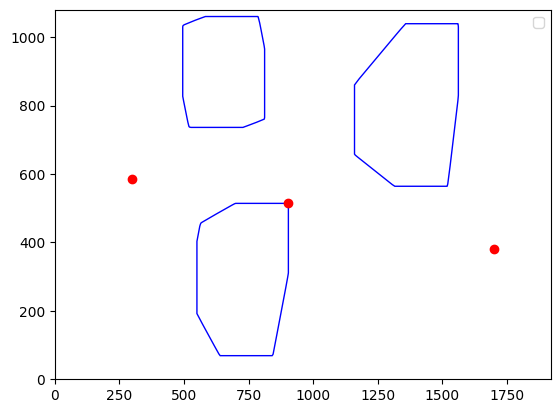

[[1699.  382.]
 [ 902.  514.]
 [ 297.  585.]]
[1700.          381.            1.70402308    0.            0.        ]
[1.69900000e+03 3.81000000e+02 1.68371599e+00 8.35882434e-01
 2.31313777e-01]
[ 1.69900000e+03  3.81000000e+02  1.70539424e+00 -3.32229938e-01
  1.82139992e-01]
[ 1.70000000e+03  3.81000000e+02  1.73594500e+00 -1.27577615e+00
  2.88018202e-01]
[ 1.70000000e+03  3.82000000e+02  1.79059140e+00 -1.27577615e+00
  2.88018202e-01]
[1.70000000e+03 3.82000000e+02 1.81076250e+00 1.49213138e-01
 2.82852024e-01]
[1.70000000e+03 3.82000000e+02 1.86623716e+00 1.49213138e-01
 2.82852024e-01]
[ 1.70000000e+03  3.82000000e+02  1.87615491e+00 -1.97392338e+00
  3.17798601e-01]
[ 1.70000000e+03  3.82000000e+02  1.93200008e+00 -1.97392338e+00
  3.17798601e-01]
[ 1.70000000e+03  3.82000000e+02  1.95517116e+00 -9.58640082e-01
  3.47906941e-01]
[1.70000000e+03 3.82000000e+02 2.01119231e+00 8.64577268e-01
 2.85708397e-01]
[1.70000000e+03 3.83000000e+02 2.03913874e+00 7.11748198e-01
 2.66642952

100%|██████████| 8/8 [00:00<00:00, 253.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


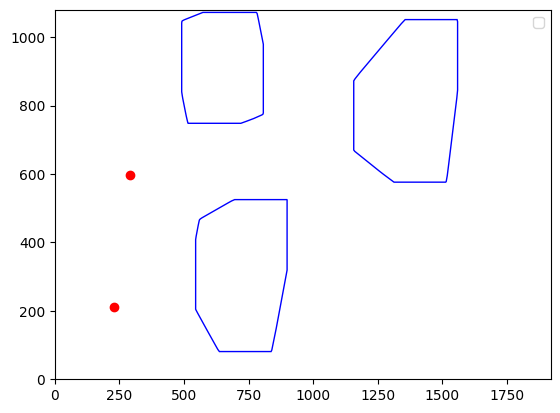

[[228.79438147 211.9305286 ]
 [292.         597.        ]]
[228.         212.           1.91868472   0.           0.        ]
[228.         212.           1.91868472   0.           0.        ]
[228.         213.           1.92224112   0.           0.        ]
[ 2.28000000e+02  2.13000000e+02  1.91868472e+00  6.75191362e-01
 -7.32960950e-02]
[ 2.28000000e+02  2.13000000e+02  1.92224112e+00  6.75191362e-01
 -7.32960950e-02]
[ 2.28000000e+02  2.12000000e+02  1.90893886e+00  8.39614674e-02
 -1.11481643e-01]
[ 2.28000000e+02  2.13000000e+02  1.88924656e+00  8.39614674e-02
 -1.11481643e-01]
[ 2.28000000e+02  2.13000000e+02  1.87930262e+00 -6.34272146e-01
 -1.19777478e-01]
[ 2.28000000e+02  2.12000000e+02  1.85335128e+00 -6.34272146e-01
 -1.19777478e-01]
[ 2.28000000e+02  2.13000000e+02  1.84340615e+00 -2.07349255e-01
 -1.22415224e-01]
[ 2.28000000e+02  2.12000000e+02  1.82077495e+00 -2.07349255e-01
 -1.22415224e-01]
[ 2.28000000e+02  2.12000000e+02  1.82077495e+00 -5.45201851e-02
 -1.0334977

In [8]:
cap = cv2.VideoCapture(1)
previousTime = time.time()

#state control variables
correctedCam = False
environmentSetup = False
redoPath = False
avoidingObstacle = False
wasKidnapped = False
aligned = False

#initializing variables
path = []
goal = np.array([0,0])
lSpeed = 0
rSpeed = 0
P_k = np.array([[r11,0,0,0,0],[0,r22,0,0,0],[0,0,r33,0,0],[0,0,0,r44,0],[0,0,0,0,r55]])

postionHistory = []


while True:
    # Read a frame from the video stream
    key = cv2.waitKey(1)
    ret, frame = cap.read()


    if not ret:
        print("Error: failed to capture image")
        break

    if not correctedCam:
        # Map the image to the corner
        position, angle, _=findThymio(frame)
        estimateState = np.array([position[0],IMAGE_HEIGHT-position[1],angle,0,0])
        cv2.imshow('Thymio Camera', frame)
        try:
            centroids = findCorners(frame)
            perspectiveMatrix = getPerspectiveMatrix(centroids)
            correctedCam = True
        except:
            print("Fail")
            continue
            
    
    
    # Correct the perspective of the image
    if correctedCam:
        frame = correctPerspectiveStream(frame,perspectiveMatrix)
        frameToPlot = frame



    current_time = time.time()
    dt = current_time - previousTime
    if dt < 0.15:
        time.sleep(0.15-dt)

    previousTime = current_time


    previousControlVector = inverseSpeedConversion(rSpeed,lSpeed,R,L,Cr,Cl)

    measLS, measRS = motorSpeeds()

    position, angle, estimateState, P_k = estimatePosition(frame,previousControlVector,dt,P_k,estimateState, measLS, measRS)

    postionHistory.append(position)



    #plot the points in position history in black
    for i in range(len(postionHistory)-1):
        cv2.circle(frameToPlot, (int(postionHistory[i][0]), int(IMAGE_HEIGHT-postionHistory[i][1])), 5, (0, 0, 0), -1)

    #plot the goal
    cv2.circle(frameToPlot, (int(goal[0]), int(goal[1])), 5, (0, 0, 255), -1)

    #plot the path lines
    for i in range(len(path)-1):
        cv2.line(frameToPlot,(int(path[i][0]),int(IMAGE_HEIGHT-path[i][1])),(int(path[i+1][0]),int(IMAGE_HEIGHT-path[i+1][1])),(255,255,255),2)
        cv2.circle(frameToPlot, (int(path[i][0]), int(IMAGE_HEIGHT-path[i][1])), 5, (255, 255, 255), -1)
        
    cv2.imshow('Thymio Camera', frameToPlot)
    
    
    if checkForKidnap():
        #cambiare le condizioni
        print("kidnapped")
        lSpeed = 0
        rSpeed = 0
        wasKidnapped = True
        continue


    if wasKidnapped:
        time.sleep(KIDNAPPING_TIME)
        wasKidnapped = False
        redoPath = True
        continue


    if not avoidingObstacle:
        leftOrRight = checkForObstacles(horiz_sensor())


    if leftOrRight != None or avoidingObstacle:
        if not avoidingObstacle:
            initTime = time.time()
        avoidingObstacle = avoidObstacle(leftOrRight, initTime, time.time())
        redoPath = True
        continue
    

    if (key == ord(' ') and environmentSetup == False) or redoPath:
        # Capture an image
        imagePath = 'capturedImage.jpg'
        cv2.imwrite(imagePath, frame)

        capturedImage = cv2.imread(imagePath)
        
        position, angle, estimateState, P_k = estimatePosition(capturedImage,previousControlVector,dt,P_k,estimateState, measLS, measRS)

        greenObjects = findGlobalObstacles(capturedImage)

        goal = findGoal(capturedImage)
        
        print(goal)

        cv2.imshow('Thymio Camera', capturedImage)
        

        path=buildGraph(greenObjects,position,goal)
        pointCount = 0
        print(path)

        if redoPath:
            redoPath = False
            continue
        environmentSetup = True
        
        #cv2.waitKey(0)  # Wait until any key is pressed to close the image window



    if environmentSetup:

        if np.linalg.norm(position - path[pointCount]) < POSITION_THRESHOLD:
            aligned = False
            pointCount += 1
            motors(0,0)

            if pointCount == len(path):
                motors(0,0)
                print("Goal reached")
                break

            continue
        
        if not aligned:
            lSpeed,rSpeed,distanceError,angleError = robotController(path[pointCount-1],path[pointCount],position,angle,dt,alignMode=True)
            motors(lSpeed,rSpeed)
            if np.abs(angleError) < 0.1:
                aligned = True
                motors(0,0)
            continue


        lSpeed,rSpeed,distanceError,angleError = robotController(path[pointCount-1],path[pointCount],position,angle,dt,alignMode=False)
        motors(lSpeed,rSpeed)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


In [9]:
motors(0,0)

# **Conclusion**

The primary objective of this Project was to develop and integrate various modules pertinent to mobile robotics. The synergy of these modules enabled the Thymio robot to navigate autonomously towards a designated target. This included the capability to circumvent unforeseen obstacles, manage the loss of camera input, and recover from dislocation incidents (commonly referred to as 'robot kidnapping').

In essence, this project offered a comprehensive exploration of the multifaceted processes integral to mobile robotics. It served as an invaluable learning experience, enriching our understanding in both technical aspects of robotics and the dynamics of collaborative teamwork. This venture not only enhanced our technical expertise but also deepened our understanding of the intricate challenges and complexities that are characteristic of mobile robotics.

# **Sources**

Course "Basics of Mobile Robotics" by Prof. Francesco Mondada (MICRO-452): https://moodle.epfl.ch/course/view.php?id=15293

Course "Multivariable Control" by Prof. Giancarlo Ferrari Trecate (ME-422): https://moodle.epfl.ch/course/view.php?id=15777

Automatic Addison: https://automaticaddison.com

mouhknowsbest (Youtube Channel): https://www.youtube.com/watch?v=aE7RQNhwnPQ

Chat-GPT4: https://chat.openai.com/

Copilot: https://copilot.github.com/

Numpy: https://numpy.org/doc/

OpenCV: https://docs.opencv.org/

Pyvisgraph: https://github.com/TaipanRex/pyvisgraph/tree/master

matplotlib: https://matplotlib.org/stable/contents.html

TDM Client: https://github.com/epfl-mobots/tdm-python/tree/main